# Predicting Hourly Departures
Accurately predicting bike departures at each station is essential for ensuring city bike users have access to bikes when needed. Departures directly reduce the number of available bikes, making them a key factor in operational planning and rebalancing strategies.

In this notebook, we develop models to predict the number of departures for the next hour at various stations. These predictions support:
- **Operational planning:** Anticipating demand at popular stations to maintain bike availability.
- **Rebalancing:** Moving bikes between stations to meet expected demand.

We explore two modeling approaches:
1. **LightGBM Regressor:** Directly predicts hourly departures.
2. **Two-phase LightGBM Model:** First classifies whether departures will be zero or non-zero, then predicts the magnitude for non-zero departures.

Feature engineering, hyperparameter tuning, and cross-validation are used to optimize model performance. SHAP values are used to understand feature importance and guide feature selection.

In [38]:
import warnings
warnings.filterwarnings("ignore", module="pkg_resources")

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics
import seaborn as sns
from lightgbm import LGBMRegressor, LGBMClassifier
from hyperopt import STATUS_OK,fmin, tpe, hp
import shap

from citybike.features import add_features
from citybike.evaluation import cv, cv_two_phase, evaluate
from citybike.hyperopt_functions import objective_reg, objective_clf

# Define data paths
CLEAN_DIR = Path("../data/clean")

### Load the data

In [2]:
dtypes = {'departure_id': str, 'departure_name': str, 
            'return_id': str, 'return_name': str}
bike_df = pd.read_csv(CLEAN_DIR / 'bike_rides_cleaned.csv', dtype=dtypes, parse_dates=['departure', 'return'])
bike_df.head()

,departure,return,departure_id,departure_name,return_id,return_name,distance,duration,departure_lat,departure_lon,departure_capacity,return_lat,return_lon,return_capacity
0,2020-04-01 00:04:08,2020-04-01 00:21:27,062,Välimerenkatu,062,Välimerenkatu,999.0,17.300000,60.159296,24.916241,16.0,60.159296,24.916241,16.0
1,2020-04-01 00:12:31,2020-04-01 00:21:34,149,Toinen linja,016,Liisanpuistikko,2372.0,8.966667,60.183164,24.944195,22.0,60.174140,24.962084,17.0
2,2020-04-01 00:16:46,2020-04-01 00:46:09,118,Fleminginkatu,105,Tilkantori,4299.0,18.016667,60.188154,24.952916,22.0,60.202839,24.893476,16.0
3,2020-04-01 00:19:29,2020-04-01 00:30:13,017,Varsapuistikko,013,Merisotilaantori,1923.0,10.650000,60.173103,24.949519,28.0,60.167870,24.975534,24.0
4,2020-04-01 00:22:32,2020-04-01 00:27:29,030,Itämerentori,067,Perämiehenkatu,1376.0,4.866667,60.163531,24.914517,40.0,60.160088,24.934066,16.0


In [3]:
weather_df = pd.read_csv(CLEAN_DIR / 'weather_cleaned.csv', parse_dates=['time'], index_col='time')
weather_df.drop(columns=['precip_missing', 'ws_missing'], inplace=True)
weather_df.head()

,temperature,wind_speed,precipitation
time,,,
2020-04-01 00:00:00,2.5,6.4,0.0
2020-04-01 01:00:00,3.1,4.4,0.0
2020-04-01 02:00:00,3.3,4.1,0.0
2020-04-01 03:00:00,3.1,3.7,0.0
2020-04-01 04:00:00,3.0,4.4,0.0


### Station selection

Usage differs significantly between stations. To reduce data size and computational requirements, we focus on the top stations by usage.

In [4]:
station_usage = bike_df['departure_id'].value_counts()

In [5]:
# Define thresholds to test
thresholds = [20, 50, 100 ,150, 200, 250, 300, 350, 400, 450]

results = {}
total_rides = len(bike_df)

for t in thresholds:
    top_stations = station_usage.head(t).index
    
    # rides that belong to valid stations
    rides_kept = bike_df[bike_df['departure_id'].isin(top_stations)]
    
    results[t] = {
        "stations_kept": len(top_stations),
        "rides_kept": len(rides_kept),
        "rides_percent": round(len(rides_kept) / total_rides * 100, 2)
    }

results_df = pd.DataFrame(results).T
print(results_df)

     stations_kept  rides_kept  rides_percent
20            20.0   2488903.0          19.20
50            50.0   4802434.0          37.05
100          100.0   7501782.0          57.88
150          150.0   9351293.0          72.15
200          200.0  10610731.0          81.87
250          250.0  11442209.0          88.29
300          300.0  12045009.0          92.94
350          350.0  12473118.0          96.24
400          400.0  12777603.0          98.59
450          450.0  12942244.0          99.86


A small number of stations account for most rides, while many are rarely used. Selecting the top 100 stations captures nearly 60% of all rides, providing a good balance between data coverage and computational efficiency.

### Hourly data

We aggregate departures to an hourly level for each selected station. Missing hours are filled with zeros to ensure a complete time series. Station coordinates and capacities are merged into the dataset.

In [6]:
num_stations = 100
bike_df['time'] = bike_df['departure'].dt.floor('h')
sample_bike_df = bike_df[bike_df['departure_id'].isin(station_usage.head(num_stations).index)]

bike_df_hourly = sample_bike_df.groupby(['time', 'departure_id']).size().reset_index(name='departures').rename(columns={'departure_id': 'station_id'})
# Fill in missing hours with 0 rides
season_hours = pd.date_range(start=bike_df['time'].min(), 
                      end=bike_df['time'].max(), 
                      freq='h')
season_hours = season_hours[(season_hours.month >= 4) & (season_hours.month <= 10)]
full_index = pd.MultiIndex.from_product([station_usage.head(num_stations).index, season_hours], names=['station_id', 'time'])
bike_df_hourly = (bike_df_hourly.set_index(['station_id', 'time'])).reindex(full_index, fill_value=0).reset_index()

# Add station coordinates and capacities
station_coords = bike_df[['departure_id', 'departure_lat', 'departure_lon', 'departure_capacity']].drop_duplicates()
bike_df_hourly = bike_df_hourly.merge(station_coords, left_on='station_id', right_on='departure_id', how='left')
bike_df_hourly.drop(columns=['departure_id'], inplace=True)
bike_df_hourly.head()

,station_id,time,departures,departure_lat,departure_lon,departure_capacity
0,030,2020-04-01 00:00:00,1,60.163531,24.914517,40.0
1,030,2020-04-01 01:00:00,1,60.163531,24.914517,40.0
2,030,2020-04-01 02:00:00,0,60.163531,24.914517,40.0
3,030,2020-04-01 03:00:00,0,60.163531,24.914517,40.0
4,030,2020-04-01 04:00:00,0,60.163531,24.914517,40.0


##### Combine with the weather data

Hourly bike data is merged with weather observations, and columns are renamed for clarity.

In [7]:
bike_df_hourly = bike_df_hourly.merge(weather_df, left_on='time', right_index=True, how='left')
bike_df_hourly.rename(
    columns={
        'departure_lat': 'lat',
        'departure_lon': 'lon',
        'departure_capacity': 'capacity'
    }, inplace=True)
bike_df_hourly = bike_df_hourly.drop_duplicates(subset=['station_id', 'time'])
bike_df_hourly.set_index('time', inplace=True)
bike_df_hourly.head()

,station_id,departures,lat,lon,capacity,temperature,wind_speed,precipitation
time,,,,,,,,
2020-04-01 00:00:00,030,1,60.163531,24.914517,40.0,2.5,6.4,0.0
2020-04-01 01:00:00,030,1,60.163531,24.914517,40.0,3.1,4.4,0.0
2020-04-01 02:00:00,030,0,60.163531,24.914517,40.0,3.3,4.1,0.0
2020-04-01 03:00:00,030,0,60.163531,24.914517,40.0,3.1,3.7,0.0
2020-04-01 04:00:00,030,0,60.163531,24.914517,40.0,3.0,4.4,0.0


### Exploratory Data Analysis

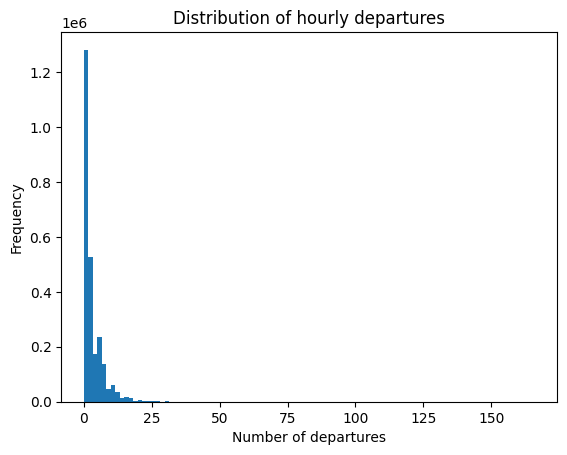

In [8]:
plt.hist(bike_df_hourly['departures'], bins=100)
plt.title('Distribution of hourly departures')
plt.xlabel('Number of departures')
plt.ylabel('Frequency')
plt.show()

The distribution of hourly departures is heavily skewed: most hours have fewer than five trips, and zero departures are very common. Peak hourly counts can exceed 100, indicating the need for models that handle zero-inflated data.

### Feature Engineering
To improve predictions, we engineer several feature types based on domain knowledge and observed temporal patterns:

- **Temporal features:** `hour`, `weekday`, `month`, `year`, and `is_weekend` capture daily and seasonal trends.
- **Lag features:** Short-term (`lag_1`, `lag_2`, `lag_3`), medium-term (`lag_6`, `lag_12`, `lag_18`), and long-term lags (`lag_24`, `lag_48`, `lag_72`, `lag_168`) capture recurring cycles. Rolling statistics (mean and standard deviation) over short, daily, and weekly windows capture variability.
- **Weather features:** Weather from the previous hour (`temperature`, `wind_speed`, `precipitation`) reflects conditions before departures. A `rain` indicator captures precipitation events.
- **Feature selection:** SHAP values are later used to evaluate and prune unhelpful or redundant features.

In [9]:
bike_df_with_lags = add_features(
    bike_df_hourly, 
    target_col='departures',
    lags=[1,2,3,6,12,18, 24, 48, 72, 168],
    same_hour_windows=[3,7],
    rolling_windows=[3, 24, 168],
    weather_cols=weather_df.columns,
    freq='h'
)
bike_df_with_lags.head()

,time,station_id,departures,lat,lon,capacity,temperature,wind_speed,precipitation,dep_lag_1,...,dep_same_hour_mean_3d,dep_same_hour_std_3d,dep_same_hour_mean_7d,dep_same_hour_std_7d,hour,weekday,month,is_weekend,year,rain
0,2020-04-08,001,1,60.155445,24.950293,31.0,7.0,8.8,0.0,0.0,...,0.666667,1.154701,0.285714,0.755929,0,2,4,0,2020,0
1,2020-04-08,003,0,60.158189,24.944927,16.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.142857,0.377964,0,2,4,0,2020,0
2,2020-04-08,004,2,60.160986,24.941776,14.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0
3,2020-04-08,005,2,60.157937,24.936156,32.0,7.0,8.8,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0
4,2020-04-08,006,0,60.162225,24.929710,24.0,7.0,8.8,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0,2,4,0,2020,0


### Model Training

#### Data Splitting

The dataset covers five years (2020–2024). Data from 2020–2023 is used for training, and 2024 is reserved for testing.

In [10]:
train = bike_df_with_lags[bike_df_with_lags.time.dt.year < 2024]
test = bike_df_with_lags[bike_df_with_lags.time.dt.year == 2024]

X_train = train.drop(["time", 'departures'], axis=1)
y_train = train['departures']
X_test = test.drop(["time", 'departures'], axis=1)
y_test = test['departures']

Cross-validation uses seven splits, each with half a season as test data and previous years as training data.

In [11]:
ts_cv= TimeSeriesSplit(n_splits=7)
splits = list(ts_cv.split(X_train, y_train))

#### Model Approaches
We test two different approaches to predict bike departures:
1. **LightGBM Regressor:** Predicts departures directly.
2. **Two-phase LightGBM Model:** A classifier predicts whether departures are zero or non-zero, a regressor predicts the magnitude for non-zero cases.

In [12]:
X_train['hour'] = X_train['hour'].astype('category')
X_train['weekday'] = X_train['weekday'].astype('category')
X_train['month'] = X_train['month'].astype('category')

X_test['hour'] = X_test['hour'].astype('category')
X_test['weekday'] = X_test['weekday'].astype('category')
X_test['month'] = X_test['month'].astype('category')

In [13]:
settings = {
    'random_state':0,
    'n_jobs':-1,
    'verbose':-1,
    'importance_type':'gain',
}

##### Regression model

In [14]:
lgbm_model = LGBMRegressor(**settings)
cv(lgbm_model, X_train, y_train, splits)

MAE: 1.461 +/- 0.155
RMSE: 2.240 +/- 0.216
R2: 0.670 +/- 0.017


##### Two-phase model

In [15]:
cv_two_phase(X_train, y_train, splits, clf=LGBMClassifier(**settings), reg=LGBMRegressor(**settings))

MAE: 1.487 +/- 0.155
RMSE: 2.280 +/- 0.213
R2: 0.658 +/- 0.019


Using all features and the default LightGBM parameters, the regression model slightly outperforms the two-phase model in cross-validation.

### Feature importance

SHAP is used to prune the features. To reduce computational cost, the SHAP is computed using 5000-row sample, 50 per station. 

In [16]:
X_sample = (
    X_train.groupby("station_id", observed=True)[X_train.columns]
           .apply(lambda g: g.sample(n=50, random_state=0))
           .reset_index(drop=True)
)
lgbm_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_sample)

shap_importance = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    "feature": X_sample.columns,
    "importance": shap_importance
}).sort_values("importance", ascending=False)

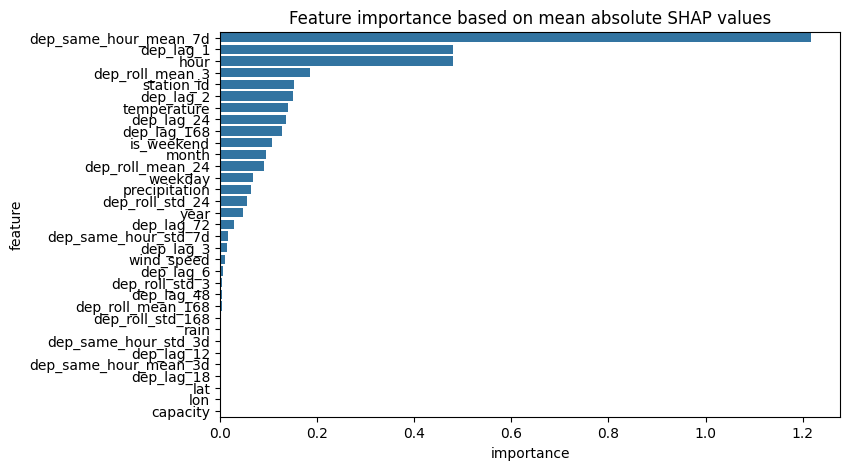

In [17]:
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=shap_df, orient='h')
plt.title('Feature importance based on mean absolute SHAP values')
plt.show()

The SHAP feature importance plot shows that the model relies primarily on lag-based features. The most important features are:  

- The 7-day average for the same hour, reflecting strong weekly patterns.  
- Short-term lags** (`lag_1`, `lag_2`), capturing recent usage trends.  
- Daily and weekly cycles (`lag_24`, `lag_168`) and rolling statistics, capturing periodic behavior and local variability.  
- Temporal features, especially the hour of the day.  
- Weather features, particularly temperature and precipitation, while wind speed and rain contribute little.  
- Station ID, which carries significant predictive value, whereas location and capacity add limited information.  

To simplify the model without sacrificing performance, features with mean absolute SHAP values below 0.01 were removed.

In [18]:
features = shap_df[shap_df['importance'] > 0.01]['feature']
print(f'Selected {len(features)}, dropped {len(shap_df) - len(features)} features')
print(features.values)

Selected 20, dropped 13 features
['dep_same_hour_mean_7d' 'dep_lag_1' 'hour' 'dep_roll_mean_3' 'station_id'
 'dep_lag_2' 'temperature' 'dep_lag_24' 'dep_lag_168' 'is_weekend' 'month'
 'dep_roll_mean_24' 'weekday' 'precipitation' 'dep_roll_std_24' 'year'
 'dep_lag_72' 'dep_same_hour_std_7d' 'dep_lag_3' 'wind_speed']


In [19]:
cv(lgbm_model, X_train[features], y_train, splits)

MAE: 1.462 +/- 0.155
RMSE: 2.240 +/- 0.215
R2: 0.670 +/- 0.017


In [20]:
cv_two_phase(X_train[features], y_train, splits, clf=LGBMClassifier(**settings), reg=LGBMRegressor(**settings))

MAE: 1.486 +/- 0.154
RMSE: 2.279 +/- 0.213
R2: 0.658 +/- 0.019


To simplify the model and focus on meaningful predictors, we dropped features with mean absolute SHAP values below 0.01. This removed negligible features without affecting predictive performance.

### Hyperparameter Tuning
Hyperparameter optimization is performed using Bayesian search (Hyperopt) over 30 iterations. The objective is to minimize MAE for regression and maximize F1-score for classification.

The tuned hyperparameters are summarized below:

| Parameter | Description | Tuned Range |
|------------|--------------|--------------|
| `num_leaves` | Maximum number of leaves per tree | 20 – 150 |
| `n_estimators` | Number of boosting iterations | 100 – 500 |
| `max_depth` | Limits tree depth to prevent overfitting | 3 – 15 |
| `learning_rate` | Step size for boosting | 0.01 – 0.3 |
| `feature_fraction` | Fraction of features used per iteration | 0.5 – 1.0 |
| `bagging_fraction` | Fraction of data used per iteration | 0.5 – 1.0 |
| `min_child_samples` | Minimum number of data points in one leaf | 5 – 50 |

In [ ]:
space = {
    "num_leaves": hp.quniform("num_leaves", 20, 150, 1),
    "n_estimators": hp.quniform('n_estimators', 100, 500, 25),
    "max_depth": hp.quniform("max_depth", 3, 15, 1),
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)),
    "feature_fraction": hp.uniform("feature_fraction", 0.5, 1.0),
    "bagging_fraction": hp.uniform("bagging_fraction", 0.5, 1.0),
    "min_child_samples": hp.quniform("min_child_samples", 5, 50, 1),
    **settings
}

best_params_single = fmin(fn=lambda p: objective_reg(p, X_train[features], y_train, splits, two_phase=False), space=space, algo=tpe.suggest, max_evals=30)
best_params_reg = fmin(fn=lambda p: objective_reg(p, X_train[features], y_train, splits, two_phase=True), space=space, algo=tpe.suggest, max_evals=30)
best_params_clf = fmin(fn=lambda p: objective_clf(p, X_train[features], (y_train > 0).astype(int), splits), space=space, algo=tpe.suggest, max_evals=30)

100%|██████████| 30/30 [19:14<00:00, 38.47s/trial, best loss: -0.8836443090543672]


In [27]:
best_params_single, best_params_reg, best_params_clf

({'bagging_fraction': np.float64(0.9057331994746333),
  'feature_fraction': np.float64(0.5892686656410099),
  'learning_rate': np.float64(0.04479216014934237),
  'max_depth': np.float64(12.0),
  'min_child_samples': np.float64(50.0),
  'n_estimators': np.float64(350.0),
  'num_leaves': np.float64(127.0)},
 {'bagging_fraction': np.float64(0.8177888306580715),
  'feature_fraction': np.float64(0.5362878147369727),
  'learning_rate': np.float64(0.06413085337918903),
  'max_depth': np.float64(10.0),
  'min_child_samples': np.float64(28.0),
  'n_estimators': np.float64(375.0),
  'num_leaves': np.float64(100.0)},
 {'bagging_fraction': np.float64(0.8442905768097371),
  'feature_fraction': np.float64(0.5163806976887504),
  'learning_rate': np.float64(0.04238748152900556),
  'max_depth': np.float64(8.0),
  'min_child_samples': np.float64(38.0),
  'n_estimators': np.float64(500.0),
  'num_leaves': np.float64(111.0)})

##### Optimal Hyperparameter Values

The optimal hyperparameters selected by Hyperopt for each model configuration are summarized below:

| Parameter | Regression | Two-Phase Regression | Two-Phase Classification | 
|------------|-------------|----------------------|---------------------------|
| `num_leaves` | 127 | 100 | 111 |
| `n_estimators` | 350 | 375 | 500 |
| `max_depth` | 12 | 10 | 8 |
| `learning_rate` | 0.045 | 0.064 | 0.042 |
| `feature_fraction` | 0.589 | 0.536 | 0.516 |
| `bagging_fraction` | 0.906 | 0.818 | 0.844 |
| `min_child_samples` | 50 | 28 | 38 |

The tuned models generally preferred:
- Moderate tree depth and leaf counts, balancing flexibility and generalization.
- Small learning rates ($\approx 0.04 - 0.06$) combined with a moderate to high number of trees, improving accuracy at the cost of longer training time.
- High bagging fraction and lower feature fraction, meaning the model uses most of the available data while sampling only about half of the features per iteration to improve regularization and reduce overfitting.

In [22]:
for param in ["num_leaves", "n_estimators", "max_depth", "min_child_samples"]:
    best_params_single[param] = int(best_params_single[param])
    best_params_reg[param] = int(best_params_reg[param])
    best_params_clf[param] = int(best_params_clf[param])

In [23]:
lgbm_model_single = LGBMRegressor(**settings, **best_params_single)
cv(lgbm_model_single, X_train[features], y_train, splits)

MAE: 1.443 +/- 0.157
RMSE: 2.216 +/- 0.217
R2: 0.677 +/- 0.015


In [24]:
cv_two_phase(X_train[features], y_train, splits, clf=LGBMClassifier(**settings, **best_params_clf), reg=LGBMRegressor(**settings, **best_params_reg))

MAE: 1.474 +/- 0.158
RMSE: 2.261 +/- 0.216
R2: 0.664 +/- 0.016


<table>
  <tr>
    <th rowspan="2">Result</th>
    <th colspan="3">Regression</th>
    <th colspan="3">Two phase</th>
  </tr>
  <tr>
    <th>MAE</th>
    <th>RMSE</th>
    <th>R<sup>2</sup></th>
    <th>MAE</th>
    <th>RMSE</th>
    <th>R<sup>2</sup></th>
  </tr>
  <tr>
    <td>Default settings</td>
    <td>1.462 +/- 0.155</td>
    <td>2.240 +/- 0.215</td>
    <td>0.670 +/- 0.017</td>
    <td>1.486 +/- 0.154</td>
    <td>2.279 +/- 0.213</td>
    <td>0.658 +/- 0.019</td>
  </tr>
  <tr>
    <td>Hyperparameter tuning</td>
    <td>1.443 +/- 0.157</td>
    <td>2.216 +/- 0.217</td>
    <td>0.677 +/- 0.015</td>
    <td>1.474 +/- 0.158</td>
    <td>2.261 +/- 0.216</td>
    <td>0.664 +/- 0.016</td>
  </tr>
</table>

Hyperparameter tuning provided a small improvement over the default LightGBM settings. LightGBM generally performs well out-of-the-box, so the gains from tuning were marginal, but still noticeable in slightly better predictive accuracy. The regression model maintained a small but a clear edge over the two-phase model across all evaluation metrics.


### Results

##### Baseline

A naive baseline uses the value from the same hour one week prior.

In [25]:
baseline_preds = test['dep_lag_168'].to_numpy()
evaluate(y_test, baseline_preds)

MAE: 1.92
RMSE: 3.30
R2: 0.330


##### LightGBM Regressor

In [35]:
lgbm_model = LGBMRegressor(**settings, **best_params_single)
lgbm_preds = lgbm_model.fit(X_train[features], y_train).predict(X_test[features])
evaluate(y_test, lgbm_preds)

MAE: 1.39
RMSE: 2.21
R2: 0.698


#### Two-Phase model

In [36]:
lgbm_model_reg = LGBMRegressor(**settings, **best_params_reg)
pos_inds = y_train > 0
lgbm_preds_reg = lgbm_model_reg.fit(X_train[features][pos_inds], y_train[pos_inds]).predict(X_test[features])
lgbm_model_clf = LGBMClassifier(**best_params_clf)
lgbm_clf_preds = lgbm_model_clf.fit(X_train[features], (y_train > 0).astype(int)).predict(X_test[features])
two_phase_preds = np.where(lgbm_clf_preds == 0, 0, lgbm_preds_reg)
evaluate(y_test, two_phase_preds)

MAE: 1.42
RMSE: 2.25
R2: 0.687


##### Regression metrics

| Model               | MAE  | RMSE | $\text{R}^2$ |
| ------------------- | ---- | ---- | ----- |
| Baseline            | 1.92 | 3.30 | 0.330 |
| LightGBM Regression | 1.39 | 2.22 | 0.698 |
| LightGBM Two-Phase  | 1.42 | 2.25 | 0.687 |

- Both LightGBM models significantly outperform the baseline.
    - For the LightGBM regression model:
        - MAE decreases by 0.53 ( $\approx 27.6$ \%)
        - RMSE decreases by 1.08 ( $\approx 32.7$ \%)
        - $\text{R}^2$ increased by 0.368 ( $\approx 111.5$ \%)

- The regression model slightly outperforms the two-phase model across all metrics.
    - Compared to the two-phase model, for the regressor: 
        - MAE decreases by 0.03 ( $\approx 2.1$ \%)
        - RMSE decreases by 0.03 ( $\approx 1.3$ \%)
        - $\text{R}^2$ increased by 0.011 ( $\approx 1.6$ \%)

    - Classification errors in the two-phase model can increase overall error.

##### Classification metrics for the Two-Phase model

              precision    recall  f1-score   support

           0     0.7990    0.7113    0.7526    171407
           1     0.8562    0.9058    0.8803    325393

    accuracy                         0.8387    496800
   macro avg     0.8276    0.8085    0.8165    496800
weighted avg     0.8365    0.8387    0.8363    496800



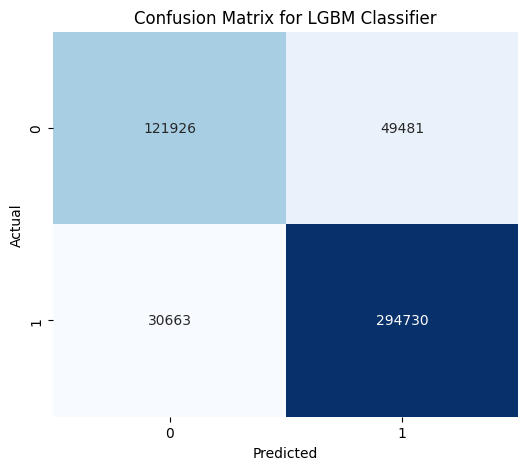

In [37]:
y_test_clf = (y_test > 0).astype(int)
print(metrics.classification_report(y_test_clf, lgbm_clf_preds, digits=4))
cm = metrics.confusion_matrix(y_test_clf, lgbm_clf_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for LGBM Classifier')
plt.show()

- The model predicts non-zero departures more accurately than zero departures.
- Recall for non-zero departures is high (0.906), but lower for zero departures (0.711), indicating some false zero predictions.
- Misclassifying zeros can increase error in the regression stage.

### Visualizing Results

We visualize one week of observed and predicted departures for three stations: the most popular, the 25th most popular, and the 80th most popular.

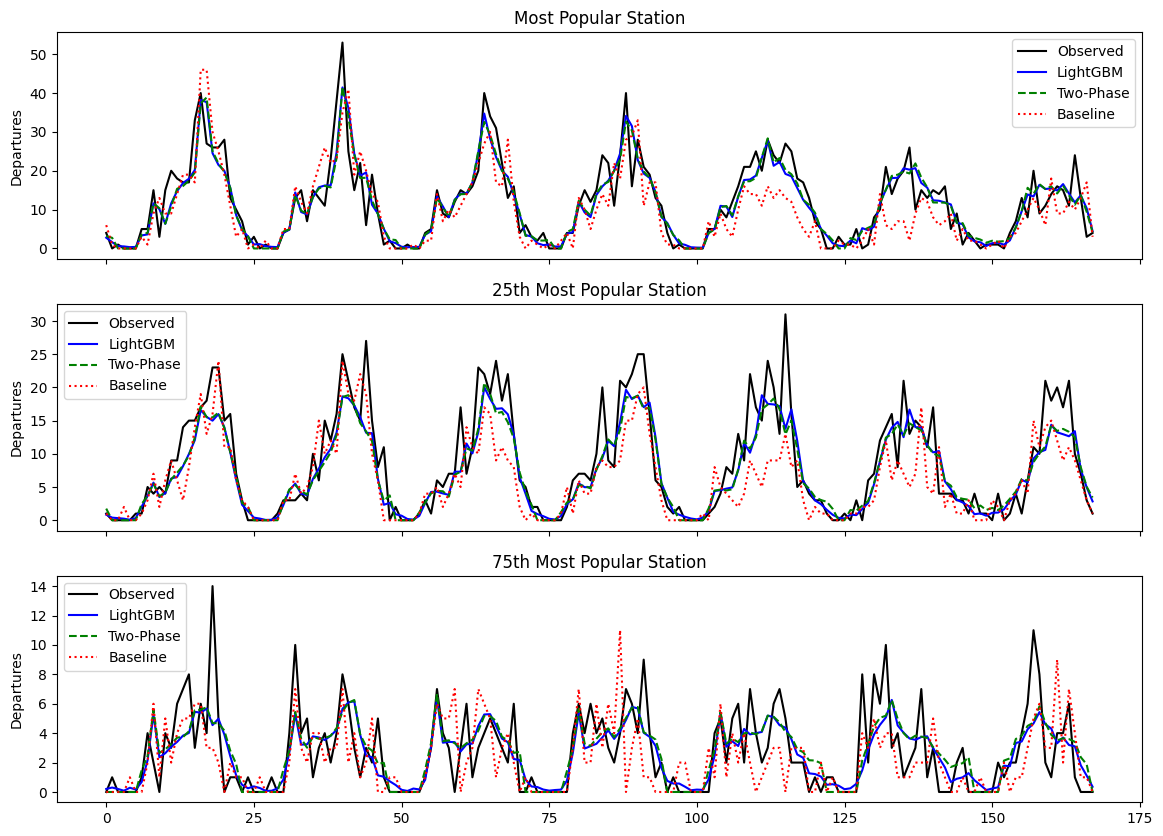

In [34]:
# 3 stations with different amount of usage
stations = top_stations[[0,24,74]]
indices = []
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
for station in stations:
    indices.append(X_test[X_test['station_id'] == station].index)

start_ind = 24*105
stations = ["Most Popular", "25th Most Popular", "75th Most Popular"]
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, ax in enumerate(axes):
    index = indices[i]
    ind = index[start_ind: start_ind + 7*24]
    ax.plot(y_test[ind ].to_numpy(), label="Observed", color="black")
    ax.plot(lgbm_preds[ind], label="LightGBM", color="blue")
    ax.plot(two_phase_preds[ind], label="Two-Phase", color="green", linestyle="--")
    ax.plot(baseline_preds[ind], label="Baseline", color="red", linestyle=":")
    ax.set_title(f"{stations[i]} Station")
    ax.set_ylabel("Departures")
    ax.legend()


Key Observations:
- LightGBM models:
    - Predictions from the standard regression and the two-phase model are almost identical.
- Most popular station:
    - LightGBM models capture the daily cycle well, with relatively small errors.
    - The largest peaks are slightly underesimated.
    - The naive baseline captures the daily cycle but performs worse overall. It does well for the first four days, but on days 5 and 6 demand was lower the previous week, leading to larger errors.
- 20th most popular station:
    - The LightGBM models are fairly good, missing some of the peak demand.
    - The naive baseline underperforms because the previous week’s demand was much lower on some days than in the observed week, illustrating a limitation of naive predictions.
- 75th most popular station:
    - As departure counts decrease and hourly variability increases, LightGBM models have more difficulties predicting the exact values.
    - Predictions follow the daily cycle, but sudden drops and spikes are often missed.

Takeaway:
- LightGBM models perform strongly, especially at high-volume stations.
- Prediction accuracy decreases for the lower-volume stations.
- The weekly naive baseline captures the daily cycle, but week-to-week variation can lead to large errors.

##### Residual Analysis

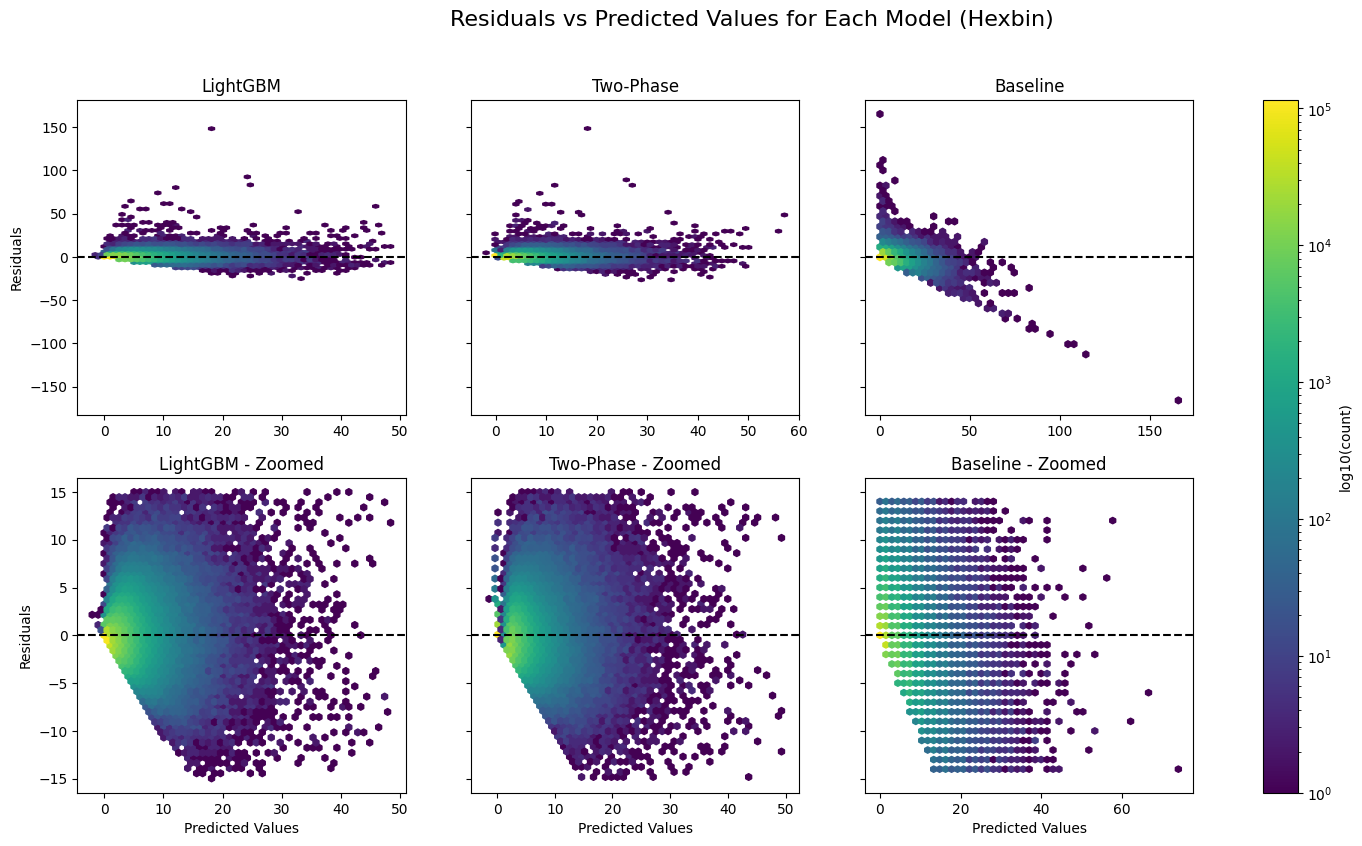

In [30]:
predictions = {
    'LightGBM': lgbm_preds,
    'Two-Phase': two_phase_preds,
    'Baseline': baseline_preds
}

fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey='row')
for i, (name, preds) in enumerate(predictions.items()):
    residuals = y_test - preds
    hb = axes[0, i].hexbin(
        preds, residuals, 
        gridsize=50,
        bins='log',
        mincnt=1
    )
    axes[0, i].axhline(0, color='black', linestyle='--')
    axes[0, i].set_title(f"{name}")
    mask = np.abs(residuals) < 15

    hb = axes[1, i].hexbin(
        preds[mask], residuals[mask], 
        gridsize=50,
        bins='log',
        mincnt=1
    )

    axes[1, i].axhline(0, color='black', linestyle='--')
    axes[1, i].set_xlabel("Predicted Values")
    axes[1, i].set_title(f"{name} - Zoomed")
    
    if i == 0:
        axes[0, i].set_ylabel("Residuals")
        axes[1, i].set_ylabel("Residuals")

# Add a single shared colorbar for all subplots
cb = fig.colorbar(hb, ax=axes.ravel().tolist())
cb.set_label('log10(count)')

plt.suptitle("Residuals vs Predicted Values for Each Model (Hexbin)", fontsize=16)
plt.show()

- First row (Full residuals):
    - Most residuals for both LightGBM models cluster near zero.
    - Residual shapes are very similar between the two models.
    - The models underestimate extreme peaks, explaining a few very large residuals.
- Second row (zoomed, -15 to 15):
    - Log counts decrease fairly consistently as residuals move away from zero, mainly along the y-axis, with a smaller decrease along the x-axis.
    - Most absolute errors are under 5, some between 5-10, very few above 10.
    - Errors remain consistent across predicted values, models handle small and medium predictions well, particularly those close to zero.
- Two-phase model:
    - Larger errors on zero predictions due to misclassified zeros.
    - Slightly higher maximum predictions than standard LightGBM.
- Baseline.
    - Residuals have a very different distribution due to broader prediction scale.
    - Includes several predictions above 50, with over 150.

### Conclusion & Future Work

The LightGBM models significantly outperformed the baseline approach, which used the previous week’s value as a predictor. Among the two configurations, the regression-based LightGBM model achieved slightly better results than the two-phase version, reaching MAE = 1.38, RMSE = 2.21, and R² = 0.699. 

Model performance was notably stronger for high-demand stations, where usage patterns are more stable and predictable. In contrast, low-demand stations with greater hour-to-hour variability proved more challenging. The models captured the daily and weekly demand cycles well but tended to underestimate the highest peaks during periods of exceptionally high usage.

Future work could explore:
- Using time series–specific architectures such as LSTMs or transformers to better capture temporal dependencies.
- Extending to multi-step forecasts (e.g., predicting 24 hours ahead).
- Predicting both departures and returns to estimate net flow.